# Определение перспективного тарифа для телеком-компании

В данном исследовании проводится предварительный анализ тарифов на небольшой выборке клиентов. Исследуются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Цель: проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов

**Тариф «Смарт»**

    Ежемесячная плата: 550 рублей
    Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        - минута разговора: 3 рубля
        - сообщение: 3 рубля
        - 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
    
    Ежемесячная плата: 1950 рублей
    Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
    Стоимость услуг сверх тарифного пакета:
        - минута разговора: 1 рубль
        - сообщение: 1 рубль
        - 1 Гб интернет-трафика: 150 рублей

**Примечание:**
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
pip install -U seaborn

Defaulting to user installation because normal site-packages is not writeable
Requirement already up-to-date: seaborn in /home/jovyan/.local/lib/python3.7/site-packages (0.11.2)
Note: you may need to restart the kernel to use updated packages.


### Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

In [3]:
df_users = pd.read_csv('/datasets/users.csv')
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


В данных есть пропуски в столбце churn_date, в дальнейшем данный столбец не потребуется, пропуски можно оставить

In [4]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [5]:
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'])
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null datetime64[ns]
tariff        500 non-null object
dtypes: datetime64[ns](1), int64(2), object(5)
memory usage: 31.4+ KB


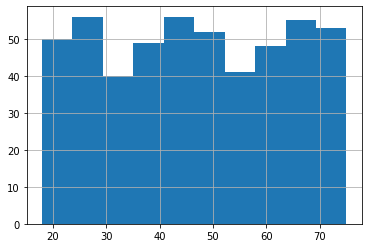

In [6]:
df_users.age.hist(bins=10)

In [7]:
df_users.city.value_counts()

Москва             99
Санкт-Петербург    39
Новосибирск        16
Омск               14
Казань             14
                   ..
Архангельск         1
Нижневартовск       1
Подольск            1
Иваново             1
Химки               1
Name: city, Length: 76, dtype: int64

In [8]:
df_users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

In [9]:
len(df_users.user_id.unique())

500

### Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

In [10]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [11]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [12]:
len(df_calls.user_id.unique())

492

Не все пользователи делали звонки

Дату звонков переведем в формат даты

In [13]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'])

In [14]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [15]:
df_calls.groupby('user_id')['duration'].count().sort_values()

user_id
1257      14
1016      20
1373      24
1442      28
1397      33
        ... 
1196    1240
1453    1440
1375    1560
1168    1692
1377    1760
Name: duration, Length: 492, dtype: int64

In [16]:
df_calls.duplicated().sum()

0

### Таблица internet (информация об интернет-сессиях):
-	id — уникальный номер сессии
-	mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
-	session_date — дата интернет-сессии
-	user_id — идентификатор пользователя


In [17]:
df_internet = pd.read_csv("/datasets/internet.csv")
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [18]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


В данных есть лишний столбец 'Unnamed: 0', который дублирует индексацию строк и никак не описан в документации к данным, удалим его.
В столбце с датой сессии хранится тип object, переведем его в datetime

In [19]:
df_internet.pop('Unnamed: 0')
df_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [20]:
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'])

In [21]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB


In [22]:
df_internet.describe()

,mb_used,user_id
count,149396.000000,149396.000000
mean,370.192426,1252.099842
std,278.300951,144.050823
min,0.000000,1000.000000
25%,138.187500,1130.000000
50%,348.015000,1251.000000
75%,559.552500,1380.000000
max,1724.830000,1499.000000


### Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение


In [23]:
df_messages = pd.read_csv("/datasets/messages.csv")
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [24]:
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Пропусков в данных нет, столбец с датой сообщения типа object, приведем его к типу datetime 

In [25]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'])
df_messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [26]:
df_messages.duplicated().sum()

0

### Таблица tariffs (информация об интернет-сессиях):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


In [27]:
df_tariffs = pd.read_csv("/datasets/tariffs.csv")
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Переведем включенный пакет интернета в гигабайты 

In [28]:
df_tariffs['mb_per_month_included'] = (df_tariffs['mb_per_month_included']/1024).astype('int')
df_tariffs = df_tariffs.rename(columns={'mb_per_month_included': 'gb_per_month_included'})

Во все таблицы с данными добавим столбец с месяцем. Также проверим,только 2018 год в данных или нет?

In [29]:
print(df_calls['call_date'].dt.year.unique())
print(df_messages['message_date'].dt.year.unique())
print(df_internet['session_date'].dt.year.unique())
df_calls['call_month'] = df_calls['call_date'].dt.month
df_messages['message_month'] = df_messages['message_date'].dt.month
df_internet['session_month'] = df_internet['session_date'].dt.month

[2018]
[2018]
[2018]


Посчтаем количество и длительность по месяцам сделанных звонков каждым пользователем.

In [30]:
group_users_call = df_calls.groupby(by = ['user_id','call_month'])['duration'].agg(['count','sum']).reset_index()
group_users_call.columns = ['user_id', 'call_month', 'count_call', 'sum_duration']
group_users_call

,user_id,call_month,count_call,sum_duration
0,1000,5,22,150.06
1,1000,6,43,158.90
2,1000,7,47,318.80
3,1000,8,52,389.87
4,1000,9,58,440.14
...,...,...,...,...
3169,1498,10,41,232.63
3170,1499,9,9,64.65
3171,1499,10,68,429.91
3172,1499,11,74,576.50


Посчитаем количество отправленных сообщений для каждого пользователя по месяцам

In [31]:
group_users_messages = df_messages.groupby(by = ['user_id','message_month'])['id'].agg(['count']).reset_index()
group_users_messages.columns = ['user_id', 'message_month', 'count_messages']
group_users_messages

,user_id,message_month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


Посчитаем количество потраченного трафика для каждого пользователя в месяц

In [32]:
group_users_internet = df_internet.groupby(by = ['user_id','session_month'])['mb_used'].agg('sum').reset_index()
group_users_internet.columns = ['user_id', 'session_month', 'sum_session']
group_users_internet

,user_id,session_month,sum_session
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


Соединим таблицы с информацией о звонках и с инофрмацией о сообщениях.

In [33]:
group_month = pd.merge(group_users_messages, group_users_call,  how='outer', left_on=['user_id','message_month'], right_on = ['user_id','call_month'])

In [34]:
group_month['message_month'].isna().sum()

496

In [35]:
group_month['call_month'].isna().sum()

39

496 месяцев было у разных пользователей, когда они делали звонки, но не отправляли смс. 

39 месяцев было у разных пользователей, когда они отправляли смс, но не делали звонки.

In [36]:
group_month['message_month'] = group_month['message_month'].fillna(group_month['call_month'])
group_month['call_month'] = group_month['call_month'].fillna(group_month['message_month'])
print(group_month['message_month'].isna().sum())
print(group_month['call_month'].isna().sum())

0
0


Соединим таблицы с информацией о звонках и сообщениях с таблицей о расходах интернет трафика.

In [37]:
group_month = pd.merge(group_month, group_users_internet,  how='outer', left_on=['user_id','message_month'], right_on = ['user_id','session_month'])
group_month

,user_id,message_month,count_messages,call_month,count_call,sum_duration,session_month,sum_session
0,1000,5.0,22.0,5.0,22.0,150.06,5.0,2253.49
1,1000,6.0,60.0,6.0,43.0,158.90,6.0,23233.77
2,1000,7.0,75.0,7.0,47.0,318.80,7.0,14003.64
3,1000,8.0,81.0,8.0,52.0,389.87,8.0,14055.93
4,1000,9.0,57.0,9.0,58.0,440.14,9.0,14568.91
...,...,...,...,...,...,...,...,...
3209,1494,9.0,NaN,9.0,66.0,469.48,9.0,16962.51
3210,1494,10.0,NaN,10.0,52.0,330.66,10.0,17767.24
3211,1494,11.0,NaN,11.0,63.0,389.17,11.0,18052.45
3212,1494,12.0,NaN,12.0,62.0,388.29,12.0,17621.21


In [38]:
group_month[['count_messages','count_call','sum_session','sum_duration']] = group_month[['count_messages','count_call','sum_session','sum_duration']].fillna(0)
group_month[['call_month','message_month']] = group_month[['call_month','message_month']].fillna(group_month['session_month'])
group_month['session_month'] = group_month['session_month'].fillna(group_month['call_month'])
group_month.loc[group_month['user_id']==1476] = group_month.query('user_id==1476').fillna(4)
group_month.isna().sum()

user_id           0
message_month     0
count_messages    0
call_month        0
count_call        0
sum_duration      0
session_month     0
sum_session       0
dtype: int64

Посчитаем для каждого пользователя сколько месяцев он проявлял какую-то активность (звонки, смс, интернет). 

Проверим соотвествует ли количество месяцев сколько пользователь подключен количеству месяцев его активности.

In [39]:
users_count_month = group_month.groupby('user_id')['session_month'].count().reset_index()
df_users = df_users.merge(users_count_month,how='outer')
df_users['month_date'] = df_users['reg_date'].dt.month
df_users_churn = df_users.query('session_month + month_date != 13')
df_users_churn

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra,6.0,5
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart,4.0,8
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,5.0,6
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart,6.0,5
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart,7.0,4
71,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,8.0,1
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,12
161,1161,65,2018-11-07,Набережные Челны,Татьяна,Голованова,2018-07-03,smart,5.0,7
191,1191,64,2018-10-03,Набережные Челны,Александр,Акиндинов,2018-06-30,smart,5.0,6
232,1232,60,2018-11-30,Томск,Виктория,Ларина,2018-10-07,smart,2.0,10


В данных есть пользователи, которые не пользовались тарифами и были подключены только в декабре. Исключим их из дальнейшего анализа

In [40]:
df_users[df_users['session_month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,12
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,NaN,12


In [41]:
df_users = df_users.dropna(subset=["session_month"])
df_users[df_users['session_month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date


In [42]:
df_users[df_users['session_month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date


Все пользователи, которые не ушли в 2018 году, проявляли активность все месяцы с момента подключения.

Для пользователей, которые отключились, сделаем проверку все ли месяцы пока они были подключены, они проявляли активность.

In [43]:
df_users_churn['churn_date'] = pd.to_datetime(df_users_churn['churn_date'])
df_users_churn['churn_month'] = df_users_churn['churn_date'].dt.month
df_users_churn

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date,churn_month
19,1019,63,2018-10-05,Томск,Игнатий,Круглов,2018-05-16,ultra,6.0,5,10
34,1034,66,2018-11-21,Вологда,Святослав,Бондарев,2018-08-26,smart,4.0,8,11
50,1050,44,2018-10-03,Тюмень,Рузана,Аничкина,2018-06-16,ultra,5.0,6,10
51,1051,37,2018-10-14,Москва,Кристина,Сомова,2018-05-28,smart,6.0,5,10
56,1056,73,2018-10-14,Иркутск,Радислав,Артемьев,2018-04-13,smart,7.0,4,10
71,1071,20,2018-08-31,Омск,Гектор,Чумаков,2018-01-09,smart,8.0,1,8
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,NaN,12,12
161,1161,65,2018-11-07,Набережные Челны,Татьяна,Голованова,2018-07-03,smart,5.0,7,11
191,1191,64,2018-10-03,Набережные Челны,Александр,Акиндинов,2018-06-30,smart,5.0,6,10
232,1232,60,2018-11-30,Томск,Виктория,Ларина,2018-10-07,smart,2.0,10,11


Все пользователи до их ухода проявляли активность ежемесячно.

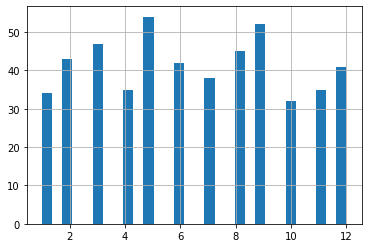

In [44]:
df_users['session_month'].hist(bins=30)

Вернемся к таблице с группировкой по пользователям и месяцам.

In [45]:
group_month.head()

,user_id,message_month,count_messages,call_month,count_call,sum_duration,session_month,sum_session
0,1000,5.0,22.0,5.0,22.0,150.06,5.0,2253.49
1,1000,6.0,60.0,6.0,43.0,158.90,6.0,23233.77
2,1000,7.0,75.0,7.0,47.0,318.80,7.0,14003.64
3,1000,8.0,81.0,8.0,52.0,389.87,8.0,14055.93
4,1000,9.0,57.0,9.0,58.0,440.14,9.0,14568.91


- удалим дублирующие столбцы с месяцами 'message_month' 'call_month'
- оставшийся столбец с месяцем приведем к целочисленному типу и переименуем в 'month'

In [46]:
group_month.pop('message_month')

0        5.0
1        6.0
2        7.0
3        8.0
4        9.0
        ... 
3209     9.0
3210    10.0
3211    11.0
3212    12.0
3213     4.0
Name: message_month, Length: 3214, dtype: float64

In [47]:
group_month.pop('session_month')

0        5.0
1        6.0
2        7.0
3        8.0
4        9.0
        ... 
3209     9.0
3210    10.0
3211    11.0
3212    12.0
3213     4.0
Name: session_month, Length: 3214, dtype: float64

In [48]:
group_month.columns = ['user_id', 'count_messages', 'month', 'count_call', 'sum_duration', 'sum_session']

In [49]:
group_month[['count_messages','month','count_call']] = group_month[['count_messages','month','count_call']].astype('int')
group_month.head()

,user_id,count_messages,month,count_call,sum_duration,sum_session
0,1000,22,5,22,150.06,2253.49
1,1000,60,6,43,158.90,23233.77
2,1000,75,7,47,318.80,14003.64
3,1000,81,8,52,389.87,14055.93
4,1000,57,9,58,440.14,14568.91


Округлим длительность звонков с избытком

In [50]:
group_month['sum_duration'] = np.ceil(group_month['sum_duration']).astype('int')
group_month['sum_duration']

0       151
1       159
2       319
3       390
4       441
       ... 
3209    470
3210    331
3211    390
3212    389
3213      0
Name: sum_duration, Length: 3214, dtype: int64

Расходы интренет трафика, переведём в гигабайты и окурглим и избытком

In [51]:
group_month['sum_session'] = group_month['sum_session']/1024
group_month['sum_session'].head(10)

0     2.200674
1    22.689229
2    13.675430
3    13.726494
4    14.227451
5    14.357900
6    14.410615
7     9.587510
8    10.602363
9    17.168066
Name: sum_session, dtype: float64

In [52]:
group_month['sum_session'] = np.ceil(group_month['sum_session']).astype('int')
group_month['sum_session']

0        3
1       23
2       14
3       14
4       15
        ..
3209    17
3210    18
3211    18
3212    18
3213     1
Name: sum_session, Length: 3214, dtype: int64

Соединим таблицу с пользователями с таблице о тарифах, а затем с таблицей с расходами.

In [53]:
df_all_users = df_users.merge(group_month, how = "outer",on='user_id')
df_all_users = df_all_users.merge(df_tariffs,how="left",left_on=['tariff'], right_on = ['tariff_name'])
df_all_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date,...,sum_duration,sum_session,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,151,3,1000,30,3000,1950,150,1,1,ultra
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,159,23,1000,30,3000,1950,150,1,1,ultra
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,319,14,1000,30,3000,1950,150,1,1,ultra
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,390,14,1000,30,3000,1950,150,1,1,ultra
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,441,15,1000,30,3000,1950,150,1,1,ultra


Вычислим ежемесячную выручку по каждому из клиентов

In [54]:
def calc_profit(raw):
    call_profit = 0
    mes_profit = 0
    session_profit = 0
    if raw['sum_duration'] > raw['minutes_included']:
        call_profit = (raw['sum_duration'] - raw['minutes_included'] ) * raw['rub_per_minute']
    if raw['count_messages'] > raw['messages_included']:
        mes_profit = (raw['count_messages'] - raw['messages_included'])*raw['rub_per_message']
    if raw['sum_session'] > raw['gb_per_month_included']:
        session_profit = (raw['sum_session'] - raw['gb_per_month_included'])*raw['rub_per_gb']
    return raw['rub_monthly_fee'] + call_profit + mes_profit + session_profit

In [55]:
df_all_users['profit'] = df_all_users.apply(calc_profit,axis=1)
df_all_users

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,session_month,month_date,...,sum_session,messages_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,profit
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,3,1000,30,3000,1950,150,1,1,ultra,1950
1,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,23,1000,30,3000,1950,150,1,1,ultra,1950
2,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,14,1000,30,3000,1950,150,1,1,ultra,1950
3,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,14,1000,30,3000,1950,150,1,1,ultra,1950
4,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,8.0,5,...,15,1000,30,3000,1950,150,1,1,ultra,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart,4.0,7,...,21,50,15,500,550,200,3,3,smart,1750
3210,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,4.0,9,...,2,50,15,500,550,200,3,3,smart,550
3211,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,4.0,9,...,18,50,15,500,550,200,3,3,smart,1150
3212,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart,4.0,9,...,18,50,15,500,550,200,3,3,smart,1408


## Анализ данных

In [56]:
def info_tariff(column, title, label):
    fig, axes = plt.subplots(1, 2, figsize=(12,6), sharey=False)
    ax = sns.histplot(data=df_all_users, x=column, hue="tariff", kde=True, ax = axes[0])
    ax.set(title = title, xlabel = label,ylabel = "Количество")
   
    ax = sns.boxplot(x="tariff", y=column, data=df_all_users,ax = axes[1])
    ax.set(title = "Диаграмма размаха", xlabel = "Тариф",ylabel = label)

    plt.show()
    
    display(df_all_users.pivot_table(index = 'tariff',
                         values = column,
                         aggfunc = ['median','mean','std','var']))

### Распределение ежемесячно затраченных минут разговора

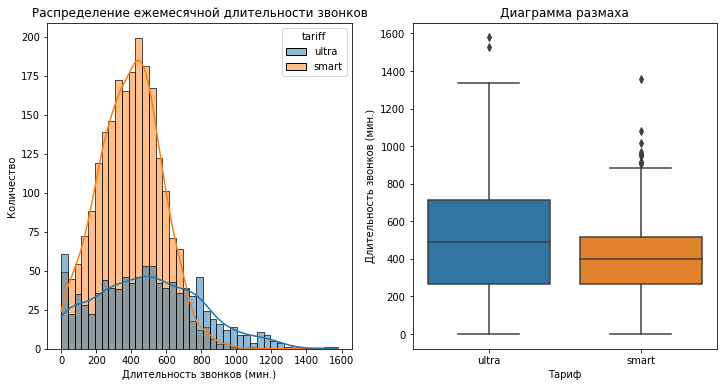

,median,mean,std,var
,sum_duration,sum_duration,sum_duration,sum_duration
tariff,,,,
smart,398,394.922387,179.980292,32392.905553
ultra,489,497.547208,299.929524,89957.719568


In [57]:
info_tariff("sum_duration","Распределение ежемесячной длительности звонков","Длительность звонков (мин.)")

- пользователи, тарифа smart ежемесячно меньше разговаривают по телефону
- из даной выборки нет ни одного пользователя, который расходовал бы весь лимит 3000 мин по тарифу ultra
- приблизительно половина пользователей тарифа smart укладываются в лимит по минутам
- распределение длительности разговора близко к нормальному
- дисперсия двух выборок по тарифам отличается существенно
- медиана и средние по обоим тарифам приблизительно равны, что показывает слабовыраженную ассиметрию. По тарифу smart в левую сторону, а по тарифу ultra в правую сторону

### Распределение ежемесячного расхода смс

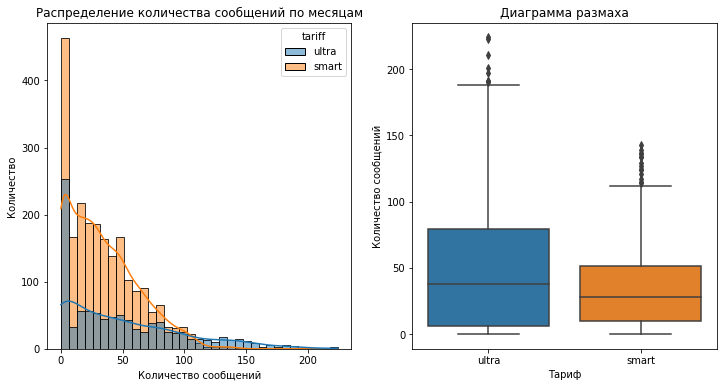

,median,mean,std,var
,count_messages,count_messages,count_messages,count_messages
tariff,,,,
smart,28,33.384029,28.227876,796.812958
ultra,38,49.363452,47.804457,2285.266143


In [58]:
info_tariff("count_messages","Распределение количества сообщений по месяцам","Количество сообщений")

Много месяцев, когда пользователи не отправляли смс. Что нельзя считать аномалией
, с распространением интернета, люди меньше пользуются сообщениями.

- из даной выборки нет ни одного пользователя, который расходовал бы весь лимит 1000 сообщений по тарифу ultra
- распределение имеет ассиметрию в большую сторону
- в среднем пользователи тарифа smart отправляют меньше сообщений
- в тарифе ultra отличие медианы (38) от среднего значения (49) существенней, а это значит, что распределение по данному тарифу имеет более выраженную правостороннюю асиметрию

### Распределение ежемесячного расхода трафика

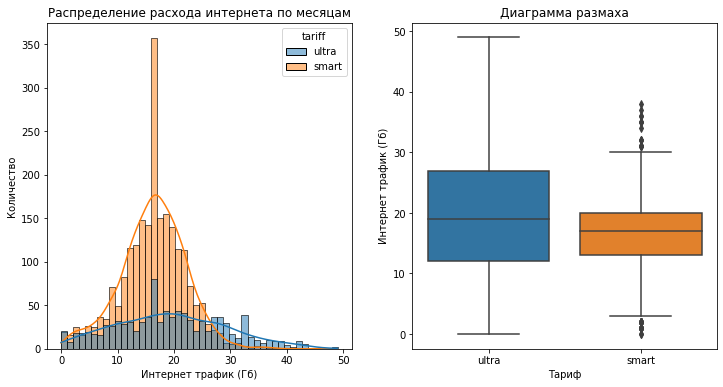

,median,mean,std,var
,sum_session,sum_session,sum_session,sum_session
tariff,,,,
smart,17,16.328847,5.747061,33.028705
ultra,19,19.494416,9.853511,97.091686


In [59]:
info_tariff("sum_session","Распределение расхода интернета по месяцам","Интернет трафик (Гб)")

- По тарифу smart ярко выраженный пик в 16 гб. Значение близко с лимитом по тарифу, что означает, многие перестают использовать интернет или продлевают только на 1 Гб, или не сразу замечают, что вышли из лимита и не продлевают его.
- По тарифу ultra в отличии от других услуг ( звонки, сообщения), есть пользователи, которые выходят за пределы лимита 30 Гб по расходу трафика.
- Согласно медиане и среднему значению, распределения по обоим тарифам являются нормальными без ассиметрии.

**Распределение ежемесячного дохода по тарифам**

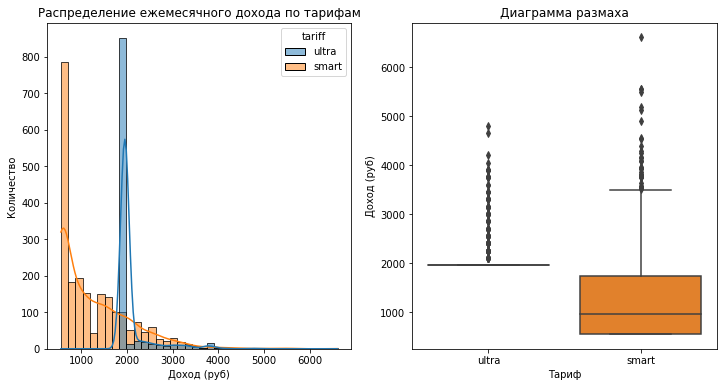

,median,mean,std,var
,profit,profit,profit,profit
tariff,,,,
smart,962,1257.588605,800.915599,641465.797016
ultra,1950,2070.152284,376.187114,141516.745079


In [60]:
info_tariff("profit","Распределение ежемесячного дохода по тарифам","Доход (руб)")

In [61]:
display(df_all_users.pivot_table(index = 'tariff',
                         values = 'profit',
                         aggfunc = 'sum'))

,profit
tariff,
smart,2803165
ultra,2039100


Пики по доходам в значениях равных абонентской плате по каждому тарифу.

- распределения с обрывом слева
- по тарифу smart распределение более скошено вправо
- по тарифу smart существенно больше стандартное отклонение и дисперсия
- по тарифу ultra, единичные случаи, когда клиенты не укладываются в лимиты и именно по интернет траффику, исходя из предыдущего анализа.  
- по тарифу smart, большинство клиентов не укладываются в лимиты и переплачивают за продление услуг.

**Вывод:**
В среднем пользователям тарифа smart требуется:
- 398 минут в месяц (хватает лимита тарифа)
- 28 сообщений (хватает лимита тарифа)
- 17 Гб (не хватает лимита тарифа)

В среднем пользователям тарифа ultra требуется:
- 489 минут в месяц (хватает лимита тарифа)
- 38 сообщений (хватает лимита тарифа)
- 19 Гб (хватает лимита тарифа)

Стоит отметить, что по среднему расходу (по звонкам и сообщениям) пользователи тарифа ultra укладывались бы и в лимиты по более дешевому тарифу smart.  


## Проверка гипотез

**Проверить:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

**Нулевая гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.

**Альтернативная гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» разная.

Гипотеза двусторонняя.

Имеются 2 выборки. Чтобы проверить гипотезу о равенстве средних двух генеральных совокупностей по тарифам "Ультра" и "Смарт" выборки должны удовлетворять следующим условиям:

    - совокупности, а значит и выборки независимы
    - выборки должны быть распределены нормально если они маленькие (<30), или быть достаточно большими, тогда нормальное распределение не обязательно
    - учесть равны ли дисперсии

**Выборки независимы**, предполагаем, что компания не может подключить одного пользователя к нескольким тарифам.

**Размеры выборок** выборки отличаются более чем в 2 раза 350 и 148, но их размеры достаточные для проверки гипотезы

**Дисперсия выборок** существенно отличаются 141516 и 641465, это учтём при проверки гипотезы

In [62]:
#функция для проверки гипотезы о среднем двух выборок
def ttest(list_1, list_2, alpha, equal_var=True):
    results = st.ttest_ind(list_1, list_2,equal_var = equal_var)
    print(f'p-value = {results.pvalue}, alpha = {alpha}')
    if results.pvalue > alpha:
        print('Нулевую гипотезу отвергать нельзя')
    else:
        print('Нулевую гипотезу можно отвергнуть и не отвергать альтернативную гипотезу')

In [63]:
df_all_users.groupby('tariff')['user_id'].count()

tariff
smart    2229
ultra     985
Name: user_id, dtype: int64

In [64]:
display(df_all_users.pivot_table(index = 'tariff',
                         values = 'profit',
                         aggfunc = 'var'))

,profit
tariff,
smart,641465.797016
ultra,141516.745079


Выборки подходят для проведения t-test, но из-за различия их размеров и дисперсий, параметр equal_var сделаем False

In [65]:
profit_tariff_ultra = df_all_users.query('tariff == "ultra"')['profit']
profit_tariff_smart = df_all_users.query('tariff == "smart"')['profit']

ttest(list_1 = profit_tariff_ultra,
      list_2 = profit_tariff_smart,
      alpha = 0.05,
      equal_var=False)
        
    
  

p-value = 6.179723168444486e-274, alpha = 0.05
Нулевую гипотезу можно отвергнуть и не отвергать альтернативную гипотезу


**Вывод:** гипотеза "Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются" не может быть отвергнута

**Проверить:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

**Нулевая гипотеза:** средняя выручка пользователей из Москвы и из других регионов одинаковая.

**Альтернативная гипотеза:** средняя выручка пользователей из Москвы и из других регионов разная.

Гипотеза двусторонняя

Проверим выполняются ли условия для проведения t-test

In [66]:
df_city_moscow = df_all_users.query('city == "Москва"')
df_city_other = df_all_users.query('city != "Москва"')
count_moscow = df_city_moscow['profit'].count()
count_other = df_city_other['profit'].count()
print(f'Количество в Москве {count_moscow}')
print(f'Количество в других регионах {count_other}')

Количество в Москве 611
Количество в других регионах 2603


In [67]:
city_moscow_var = df_city_moscow['profit'].var()
city_other_var = df_city_other['profit'].var()
print(f'Дисперсия выборки по Москве {city_moscow_var}')
print(f'Дисперсия выборки по остальным регионам {city_other_var}')

Дисперсия выборки по Москве 562832.1982935794
Дисперсия выборки по остальным регионам 644059.3108572472


- выборки существенно отличаются, но достаточные для проведения ttest
- дисперсии существенно отличаются
- t-test можно проводить, но с equal_var = False

In [68]:
ttest(list_1 = df_city_moscow['profit'],
      list_2 = df_city_other['profit'],
      alpha = 0.05,
      equal_var = False
     )

p-value = 0.46532858228722906, alpha = 0.05
Нулевую гипотезу отвергать нельзя


**Вывод:** гипотеза "Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов" может быть отвергнута

## Общий вывод

In [69]:
display(df_all_users.pivot_table(index = 'tariff',
                         values = ['profit','count_messages','sum_duration','sum_session'],
                         aggfunc = ['mean','sum']))


mean                                                  sum  \
       count_messages       profit sum_duration sum_session count_messages   
tariff                                                                       
smart       33.384029  1257.588605   394.922387   16.328847          74413   
ultra       49.363452  2070.152284   497.547208   19.494416          48623   

                                          
         profit sum_duration sum_session  
tariff                                    
smart   2803165       880282       36397  
ultra   2039100       490084       19202

- средние значения ежемесячного дохода по тарифам smart и ultra различны для всех абонентов
- для данной выборки ежемесячный доход по тарифу ultra = 2070 больше, чем по тарифу smart = 1257, при этом пользователи в среднем по звонкам и смс укладывались бы в тариф smart. И переплачивали бы лишь за превышение лимита интернет трафика на 4 Гб, а это +800 руб по тарифу smart. 
- стоит отметить, что суммарно по тарифу smart больше доход за год, чем ultra, это связано с большим количеством пользователей подключенных к smart
- неважно клиент из Москвы или нет